# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [3]:
from pyspark.sql.functions import col

In [4]:
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [5]:
#set seaborn style
sns.set(style="whitegrid")

In [6]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [8]:
df.limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [9]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [11]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [12]:
df.count()

286500

In [13]:
for col_ in df.columns:
    print(col_,df.filter(col(col_).isNull()).count())

artist 58392
auth 0
firstName 8346
gender 8346
itemInSession 0
lastName 8346
length 58392
level 0
location 8346
method 0
page 0
registration 8346
sessionId 0
song 58392
status 0
ts 0
userAgent 8346
userId 0


In [14]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [15]:
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [16]:
df.dropDuplicates().count()

286500

In [17]:
#observation:no duplicates

In [18]:
#stats:

In [19]:
stats_df = df.describe().toPandas().set_index("summary")
all_stats =spark.createDataFrame(stats_df.reset_index()).cache()
stats_df

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
summary,,,,,,,,,,,,,,,,,,
count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [20]:
df.filter(isnull(df['userId'])).count()

0

In [21]:
# Create a user defined function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the udf on the ts column
df_cleaned = df.withColumn("time", get_time(df.ts))

In [22]:
df_cleaned.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,time
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [23]:
df_cleaned.createOrReplaceTempView("Sparkify_local_cleaned")

In [24]:
spark.sql('''
        SELECT DISTINCT(auth)
        FROM Sparkify_local_cleaned
''').show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [25]:
spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY auth
        ORDER BY user_counts DESC
''').show()

+----------+-----------+
|      auth|user_counts|
+----------+-----------+
| Logged In|        225|
| Cancelled|         52|
|Logged Out|          1|
|     Guest|          1|
+----------+-----------+



In [26]:
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY gender
        ORDER BY user_counts DESC
''')
gender_count.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
|  null|          1|
+------+-----------+



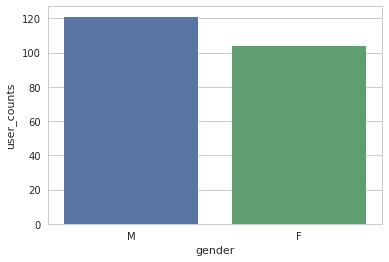

In [27]:

sns.barplot(x='gender',y='user_counts',data=gender_count.toPandas());

In [28]:
spark.sql('''
        SELECT count(*)
        FROM Sparkify_local_cleaned
        where userid != ''
''').show()

+--------+
|count(1)|
+--------+
|  278154|
+--------+



In [29]:
spark.sql('''
        SELECT count(*)
        FROM Sparkify_local_cleaned
        where userid = ''
''').show()

+--------+
|count(1)|
+--------+
|    8346|
+--------+



In [30]:
df2 = spark.sql('''
        SELECT *
        FROM Sparkify_local_cleaned
        where userid != ''
''')

In [31]:
df2.count()

278154

In [32]:
df2.createOrReplaceTempView("Sparkify_local_cleaned2")

In [33]:
spark.sql('''
        SELECT COUNT(DISTINCT(itemInSession)) AS item_counts
        FROM Sparkify_local_cleaned2
''').show()

+-----------+
|item_counts|
+-----------+
|       1311|
+-----------+



In [35]:
length_data = spark.sql('''
        SELECT length
        FROM Sparkify_local_cleaned2
''')

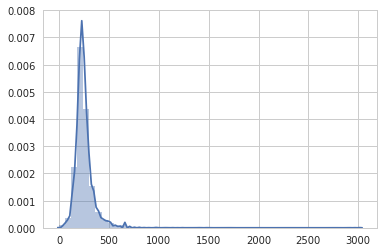

In [36]:
sns.distplot(length_data.toPandas().dropna());

In [37]:
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned2
        GROUP BY level
        ORDER BY user_counts DESC
''').show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



In [39]:
location_count = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned2
        GROUP BY location
        ORDER BY user_counts DESC
''').toPandas()

In [40]:

#split city and state
location_count = location_count.join(location_count['location'].str.split(',',expand=True).rename(columns={0:'city',1:'state'})).drop('location',axis=1)

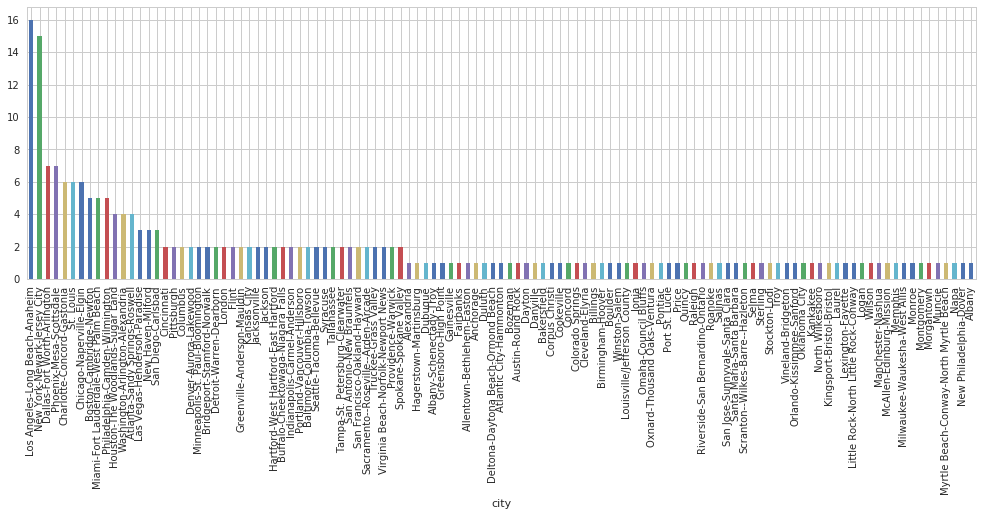

In [41]:
location_count.groupby('city')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

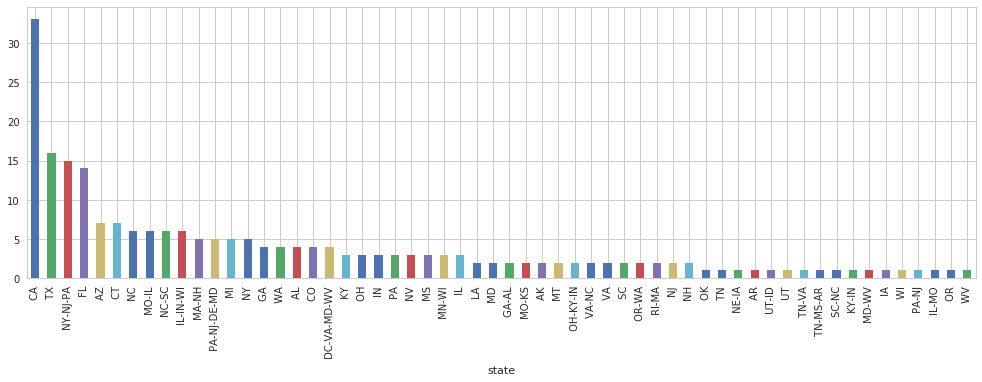

In [42]:
location_count.groupby('state')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

In [44]:
spark.sql('''
        SELECT page,COUNT(userId) AS user_counts
        FROM Sparkify_local_cleaned2
        GROUP BY page
        ORDER BY user_counts DESC
''').toPandas()

,page,user_counts
0,NextSong,228108
1,Thumbs Up,12551
2,Home,10082
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Logout,3226
7,Thumbs Down,2546
8,Downgrade,2055
9,Settings,1514


In [45]:
userAgent_count = spark.sql('''
        SELECT userAgent,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned2
        GROUP BY userAgent
        ORDER BY user_counts DESC
''').toPandas()

In [46]:

def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

In [47]:
userAgent_count['browser'] = userAgent_count['userAgent'].apply(get_browser)

In [48]:
platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}

In [49]:
userAgent_count['platform'] = userAgent_count['userAgent'].str.extract(r'\(([^\)]*)\)')[0].str.split(';').str[0].map(platform_dict)

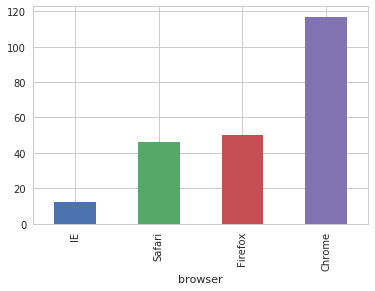

In [50]:

userAgent_count.groupby('browser')['user_counts'].sum().sort_values().plot(kind='bar');

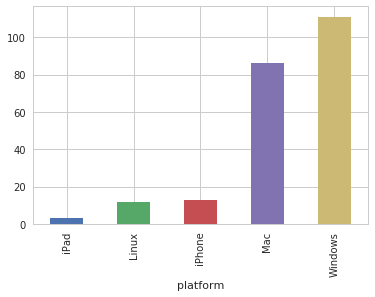

In [51]:
userAgent_count.groupby('platform')['user_counts'].sum().sort_values().plot(kind='bar');


In [52]:
time_data = spark.sql('''
        SELECT time,userId
        FROM Sparkify_local_cleaned2
''').toPandas()

In [53]:
time_data['time'] = pd.to_datetime(time_data['time'])

In [54]:
weekday_dict = {0:'Mon.',1:'Tues.',2:'Wed.',3:'Thur.',4:'Fri.',5:'Sat.',6:'Sun.'}
time_data['weekday'] = time_data['time'].dt.weekday.map(weekday_dict)
time_data['day'] = time_data['time'].dt.day
time_data['hour'] = time_data['time'].dt.hour

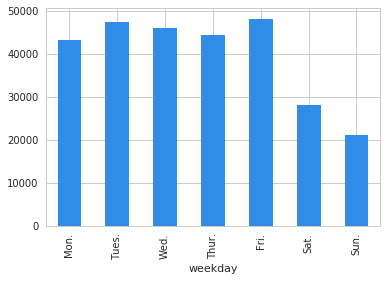

In [55]:
time_data.groupby('weekday')['userId'].count().loc[list(weekday_dict.values())].plot(kind='bar',color='#318ce7');

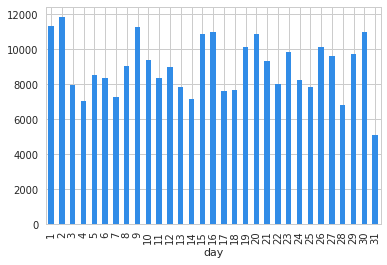

In [56]:
time_data.groupby('day')['userId'].count().plot(kind='bar',color='#318ce7');

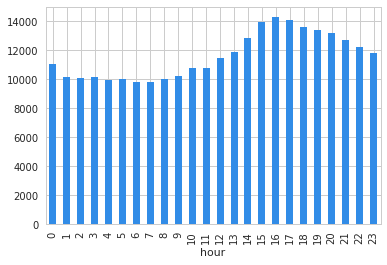

In [57]:
time_data.groupby('hour')['userId'].count().plot(kind='bar',color='#318ce7');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.